## Chapter 7. 앙상블 학습과 랜덤 포레스트

In [31]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

#### 7.1 Voting Classifier

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=2023)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2023)

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [35]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.784
RandomForestClassifier 0.84
SVC 0.824
VotingClassifier 0.824


#### 7.2 Bagging and Pasting

In [36]:
# Decision Tree Classifier 500개 ensemble
# 각 분류기는 중복을 허용하여 무작위 선택된 100개의 샘플로 훈련 (배깅)
# 페이스팅을 사용하려면 boostrap=False 로 지정 

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=2023
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [37]:
# oob 평가

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, oob_score=True, random_state=2023
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
print(bag_clf.oob_score_)
print(accuracy_score(y_test, y_pred))

0.928
0.832


In [38]:
bag_clf.oob_decision_function_
# 첫 번째 훈련 샘플이 양성 클래스에 속할 확률 93%

array([[0.0610687 , 0.9389313 ],
       [0.80851064, 0.19148936],
       [1.        , 0.        ],
       [0.82901554, 0.17098446],
       [0.02997275, 0.97002725],
       [0.0625    , 0.9375    ],
       [1.        , 0.        ],
       [0.91863517, 0.08136483],
       [0.89378238, 0.10621762],
       [0.95949367, 0.04050633],
       [0.02910053, 0.97089947],
       [0.775     , 0.225     ],
       [0.99469496, 0.00530504],
       [0.94736842, 0.05263158],
       [0.71352785, 0.28647215],
       [0.7284264 , 0.2715736 ],
       [0.00524934, 0.99475066],
       [0.08831169, 0.91168831],
       [0.25      , 0.75      ],
       [0.81746032, 0.18253968],
       [0.23848238, 0.76151762],
       [0.99737533, 0.00262467],
       [0.7605985 , 0.2394015 ],
       [0.70284238, 0.29715762],
       [0.0248139 , 0.9751861 ],
       [0.99739583, 0.00260417],
       [0.        , 1.        ],
       [0.03571429, 0.96428571],
       [1.        , 0.        ],
       [0.77173913, 0.22826087],
       [0.

#### 7.4 Random Forest

In [39]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [40]:
# BaggingClassifier를 활용한 Randomforest 유사 모델
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features='auto', max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1
)

In [41]:
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'], iris['target'])
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.1002291119096937
sepal width (cm) 0.023475017320773322
petal length (cm) 0.42288438496625425
petal width (cm) 0.4534114858032788


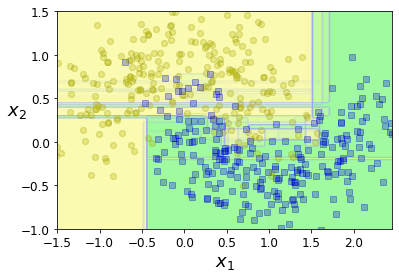

In [42]:
# 15 개 결정 트리의 결정 경계 중첩
# 개별 결정 트리는 불완전하지만 앙상블되면 매우 좋은 결정 경계를 만듦

plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X_train[indices_with_replacement], y_train[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.02, contour=False)

plt.show()

#### 7.5 Boosting

In [43]:
# DecisionTreeClassifier가 AdaBoostClassifier의 기본 추정기가 됨
# 200개의 아주 얕은 결정 트리를 기반으로 AdaBoostClassifier 훈련

from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm='SAMME.R', learning_rate=0.5
)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

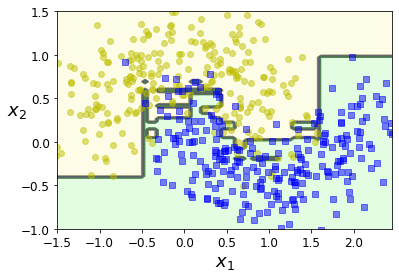

In [44]:
plot_decision_boundary(ada_clf, X, y)

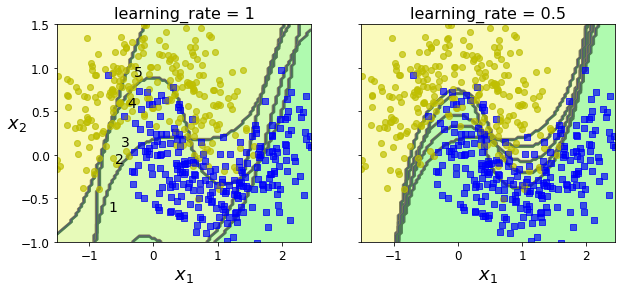

In [45]:
m = len(X_train)

fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)
        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum() # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r) # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha) # equation 7-3
        sample_weights /= sample_weights.sum() # normalization step
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)
    else:
        plt.ylabel("")

plt.show()

In [15]:
# 잡음이 섞인 2차 곡선 형태의 훈련 세트
import numpy as np

np.random.seed(2023)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [16]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [18]:
y2 = y-tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

In [19]:
y3 = y2-tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

In [21]:
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([0.58005765])

In [22]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

In [23]:
# 120개의 트리로 GBRT 앙상블을 훈련시키고 최적의 트리 수를 찾기 위해 각 훈련 단계에서 검증 오차를 측정
# 마지막에 최적의 트리 수를 사용해 새로운 GBRT 앙상블을 훈련시킴

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=35)

In [24]:
gbrt.staged_predict(X_val)

<generator object GradientBoostingRegressor.staged_predict at 0x000001D121C87190>

In [26]:
errors, len(errors)

([0.05484107898838654,
  0.04716290312435539,
  0.041033853519770326,
  0.03570092646512685,
  0.031264094313768996,
  0.027551198567509583,
  0.02436011649461281,
  0.02171362396273817,
  0.01951359046949401,
  0.01709017443378743,
  0.015168533776527939,
  0.013577501338192528,
  0.012216952789973754,
  0.011141168084327852,
  0.010042956050029965,
  0.009195551460993708,
  0.008389799744661378,
  0.007803488770130575,
  0.007354028347843385,
  0.006889857991585258,
  0.006577972552346354,
  0.006182636839060153,
  0.005854596160421655,
  0.00557237691358874,
  0.005431023834296644,
  0.0053227734490708676,
  0.005196172382243573,
  0.004986309292351175,
  0.004913811845649782,
  0.004738756439198487,
  0.004600746187756694,
  0.004594137923126255,
  0.0045413860570621386,
  0.004508102174872897,
  0.004469335790345402,
  0.004498942038655954,
  0.004537963318465778,
  0.004571479175808151,
  0.004600946359480738,
  0.004595845172265374,
  0.004566761554480986,
  0.004597731009055214

In [27]:
# 연속해서 다섯 번의 반복동안 검증 오차가 향상되지 않으면 훈련을 멈춤

gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float('inf')
error_going_up = 0

for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break

In [28]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

In [30]:
import warnings; warnings.filterwarnings('ignore')

xgb_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)

[0]	validation_0-rmse:0.28298
[1]	validation_0-rmse:0.21259
[2]	validation_0-rmse:0.16294
[3]	validation_0-rmse:0.12998
[4]	validation_0-rmse:0.10787
[5]	validation_0-rmse:0.09389
[6]	validation_0-rmse:0.08709
[7]	validation_0-rmse:0.08258
[8]	validation_0-rmse:0.07983
[9]	validation_0-rmse:0.07939
[10]	validation_0-rmse:0.07931
[11]	validation_0-rmse:0.07992
[12]	validation_0-rmse:0.07980
